# Data and Imports

In [23]:
import sklearn.datasets
import urllib.request
import os
import random

import numpy as np
from proxskip.types import Vector
from proxskip.data import DataLoader
from proxskip.types import ProximityOperator, Vector
from proxskip.model import Model
from proxskip.loss import LossFunction
from proxskip.optimizer import ProxSkip, StochasticProxSkip

# set a seed
np.random.seed(69)
random.seed(69)

In [24]:
w8a_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"

data_path = './w8a'
if not os.path.exists(data_path):
    f = urllib.request.urlretrieve(w8a_url, data_path)
DATA, LABELS = sklearn.datasets.load_svmlight_file(data_path)

In [25]:
NUM_DEVICES = 32
DEVICES_DATA = [DATA[i::NUM_DEVICES] for i in range(NUM_DEVICES)]
DEVICES_LABELS = [LABELS[i::NUM_DEVICES] for i in range(NUM_DEVICES)]
# make sure to have all the batches with the exact same size (a condition added to avoid any issues in data loading)
min_size = min([A.shape[0] for A in DEVICES_DATA])
DEVICES_DATA = [A[:min_size] for A in DEVICES_DATA]
DEVICES_LABELS = [b[:min_size] for b in DEVICES_LABELS]

# W8A Linear Model

In [26]:
from proxskip.types import Vector

class W8ALinearModel(Model):
    def __init__(self, num_features: int, lambda_, weights=None):
        self.num_features = num_features
        if weights is None:
            self.weights = np.random.rand(num_features, 1)
        else:
            self.weights = weights.copy()
        self.lambda_ = lambda_
        
    def forward(self, x: Vector) -> Vector:
        """Forward pass of the model.
        
        Args:
            x: Input vector. Shape (batch_size, num_features).
            
        Returns:
            Output vector. Shape (batch_size, 1).
        """
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        assert x.shape[1] == self.num_features, \
            f"Input shape does not match expected shape. {x.shape[1]} != {self.num_features}"

        # (B, N) x (N, 1) - > (B, 1)
        output = x @ self.weights
        if output.ndim == 1:
            output = output.reshape(-1, 1)

        assert output.shape == (x.shape[0], 1), \
            f"Output shape does not match expected shape. {output.shape} != {(x.shape[0], 1)}"
            
        return output
    
    def backward(self, x: Vector, upstream: Vector) -> Vector:
        """Backward pass of the model.
        
        Args:
            x: Input vector. Shape (batch_size, num_features).
            upstream: Upstream gradient. Shape (batch_size, 1).
            
        Returns:
            Gradient with respect to the weight. Shape (batch_size, num_features).
        """
        output = self.forward(x)
        assert upstream.shape == output.shape, \
            f"Upstream gradient shape does not match output shape. {upstream.shape} != {output.shape}"
            
        grad = x.T @ upstream
        assert grad.shape == self.weights.shape, \
            f"Gradient shape does not match weights shape. {grad.shape} != {self.weights.shape}"
            
        return grad + self.lambda_ * self.params()
        
        # return self.weights @ upstream.T  + self.lambda_ * self.params()
    
    def params(self) -> Vector:
        return self.weights
    
    def update(self, params: Vector) -> None:
        self.weights = params

In [27]:
from proxskip.model import Model
from proxskip.types import Vector
from proxskip.consensus import ConsesusProx

class LogisticLoss(LossFunction):
    def __init__(self, lambda_) -> None:
        super().__init__()
        self.lambda_ = lambda_
        
    def upstream_gradient(self, m: Model, X: Vector, y: Vector) -> Vector:
        y_hat = m.forward(X)
        if y.ndim == 1:
            y = y[:, None]
        s = np.exp(y * y_hat)
        return (-y / (1 + s)) / y.shape[0]
            
    def loss(self, m: Model, X: Vector, y: Vector) -> Vector:
        if y.ndim == 1:
            y = y[:, None]
        y_hat = m.forward(X)
        s = np.exp(-y * y_hat)
        return (np.log(1 + s).mean() + (self.lambda_ / 2) * m.params().T @ m.params()).item()


In [28]:
from proxskip.stochastic_dataloader import StochasticBatchedDataset

BATCH_SIZE = 50
dataloaders = [StochasticBatchedDataset(data=DEVICES_DATA[i], labels=DEVICES_LABELS[i], batch_size=BATCH_SIZE) for i in range(NUM_DEVICES)]
L = np.max(np.array([dataloader.L for dataloader in dataloaders]))
lambda_ = L / 10 ** 4

# the final expression of L is the sum of 'initial' L and the regularization parameter.
L = L + lambda_
num_iterations = 10**4
comminucation_rate = 50
comminication_rounds = num_iterations // comminucation_rate
proxy_probability = np.sqrt(lambda_ / L)
w0 = [np.random.rand(DEVICES_DATA[i].shape[1], 1) for i in range(NUM_DEVICES)]
org_w0 = w0[0]

In [29]:
import os
import pickle
from scipy.optimize import minimize

if not os.path.exists('true_min.pkl'):
    # Finding true minimum to compare with
    def loss(w):
        return LogisticLoss(lambda_).loss(W8ALinearModel(DATA.shape[1], lambda_, w), DATA, LABELS)

    res = minimize(loss, np.random.rand(DATA .shape[1]), method='BFGS', tol=10**-8)
    true_min = res.fun
    pickle.dump(true_min, open('true_min.pkl', 'wb'))
    print(res)
else:
    with open('true_min.pkl', 'rb') as f:
        true_min = pickle.load(f)


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.15911168496945277
        x: [-8.804e-01 -9.270e-01 ... -7.391e-02  9.320e-02]
      nit: 305
      jac: [-1.863e-09 -3.725e-09 ... -1.863e-09  0.000e+00]
 hess_inv: [[ 1.113e+01  1.071e+01 ... -4.234e+00  2.519e-01]
            [ 1.071e+01  1.541e+01 ... -5.551e+00  2.247e+00]
            ...
            [-4.234e+00 -5.551e+00 ...  2.012e+01 -2.648e-01]
            [ 2.519e-01  2.247e+00 ... -2.648e-01  1.360e+01]]
     nfev: 92708
     njev: 308


In [37]:
models = [
    W8ALinearModel(DEVICES_DATA[i].shape[1], lambda_, w0[i]) for i in range(NUM_DEVICES)
]

loss_fn = LogisticLoss(lambda_)
l0_avg = np.mean([loss_fn.loss(models[i], *dataloaders[i].get()) for i in range(NUM_DEVICES)])
print(f"l0_avg: {l0_avg}")


ps_optimizer = StochasticProxSkip(
    models=models,
    dataloaders=dataloaders,
    loss=loss_fn,
    prox=ConsesusProx(),
    num_iterations=num_iterations ** 2, # to have `comminication_rounds` of loss values
    learning_rate=1 / L,
    p=proxy_probability,
)

l0_avg: 5.220071956452143


In [38]:
from tqdm import trange
import proxskip.stochastic_dataloader as sdl
import importlib
importlib.reload(sdl)

progress = trange(comminication_rounds)
c = 0
while True:
    on_prox = ps_optimizer.step()

    if on_prox:
        progress.set_description(f"loss={ps_optimizer._step['loss'][-1]:.6f}")
        progress.update(1)
        c += 1

    if on_prox is None or c == comminication_rounds:
        break
        

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_220426/1621056780.py:14: RuntimeWarning: overflow encountered in exp
  s = np.exp(y * y_hat)
loss=0.321838: 100%|██████████| 10/10 [00:03<00:00,  2.03it/s]

11
5.06096027148269 0.1627261116440208


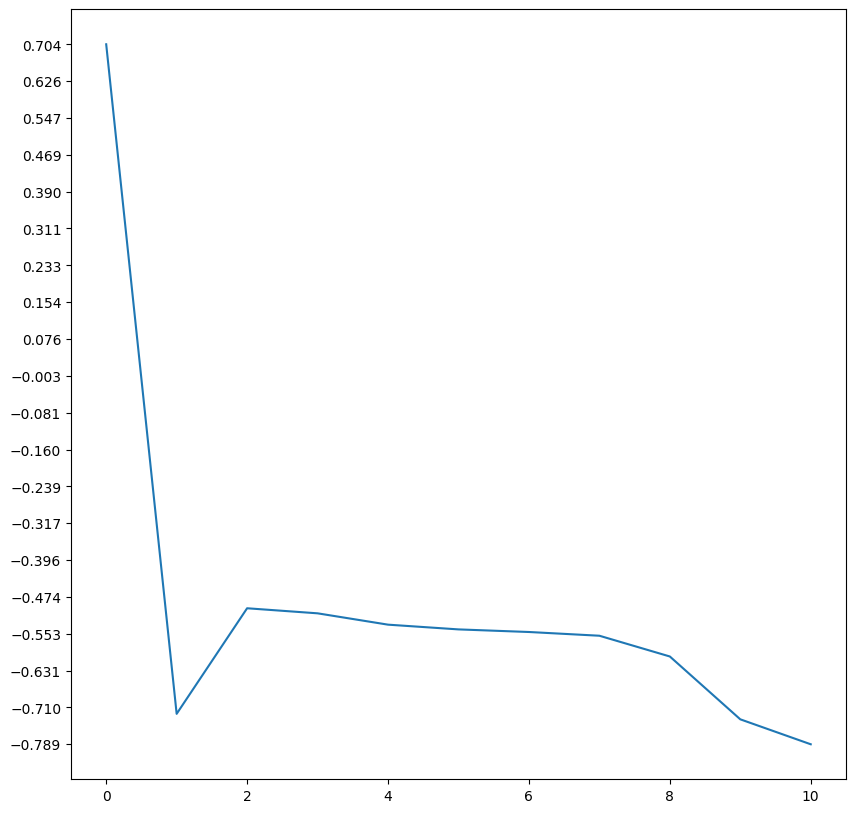

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
proxskip_criterion = [l0_avg - true_min] + [x - true_min for x in ps_optimizer._step['loss']]
print(len(proxskip_criterion))
print(max(proxskip_criterion), min(proxskip_criterion))

# plt.yscale('log')
proxskip_criterion = np.log10([max(pc, 10 ** -8) for pc in proxskip_criterion])
plt.yticks(np.linspace(min(proxskip_criterion), max(proxskip_criterion), num=20))
plt.plot([x for x in proxskip_criterion])

In [40]:
import proxskip.optimizer as opt
importlib.reload(opt)
from proxskip.optimizer import LocalGD

lgd_optimizer = LocalGD(
    models=[W8ALinearModel(DEVICES_DATA[i].shape[1], lambda_, w0[i]) for i in range(NUM_DEVICES)],
    dataloaders=dataloaders,
    loss=LogisticLoss(lambda_),
    num_iterations=num_iterations,
    learning_rate=1 / L,
    communication_rate=comminucation_rate,
)

In [42]:
from tqdm import trange

progress = trange(num_iterations)

for _ in progress:
    on_prox = lgd_optimizer.step()
    if on_prox is None:
        break
    if on_prox:
        progress.set_description(f"loss={lgd_optimizer._step['loss'][-1]:.4f}")

loss=0.1603:  34%|███▎      | 3359/10000 [00:06<00:13, 496.04it/s]


In [43]:
lgd_steps = [l0_avg - true_min] + [x - true_min for x in lgd_optimizer._step['loss']]
print(len(lgd_steps))
print(min(lgd_steps))
lgd_steps = [np.log10(max(x, 10 ** -8)) for x in lgd_steps]

11
0.001144054872679684


Text(0, 0.5, 'Loss')

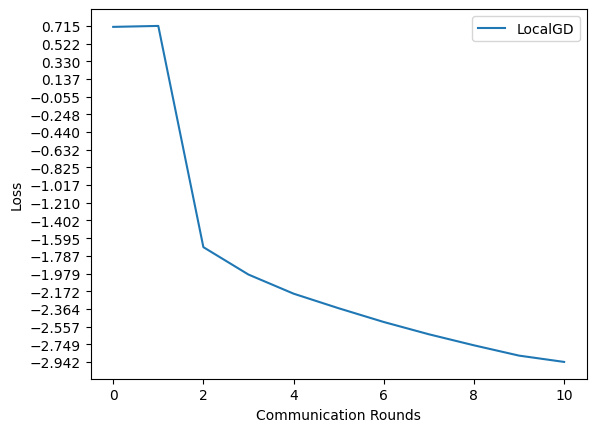

In [44]:
# plt.plot([x for x in proxskip_criterion])
plt.plot(lgd_steps)
plt.legend(['LocalGD'])
plt.yticks(np.linspace(min(lgd_steps), max(lgd_steps), num=20))
plt.xlabel('Communication Rounds')
plt.ylabel('Loss')